# Expanded Symbolic Derivations and Numerical Verification

This notebook provides a comprehensive derivation of the results in `tc_geom.pdf`. We perform step-by-step symbolic tensor contractions to derive the asymptotic variance of the difference of Sharpe ratios. We also include a geometric visualization section and a Monte Carlo simulation to empirically verify the formula.

In [1]:
import sympy as sp
from sympy import Matrix, symbols, sqrt, simplify, expand, init_printing, diff, eye, diag, Rational
from sympy.stats import Normal, density, E, variance, covariance
import numpy as np

init_printing()

## Part 1: Geometric Decompositions (Symbolic)

We verify the risk decomposition Lemma from Section 2 of the notes.
Let $s^i$ be the skill vector and $p^i$ be the implemented risk vector.

In [2]:
# Define abstract vectors in 3D for visualization/verification purpose
s = Matrix(symbols('s_1 s_2 s_3', real=True))
p = Matrix(symbols('p_1 p_2 p_3', real=True))

# Inner product and Norm squared (Euclidean metric)
def inner(u, v): return (u.T * v)[0]
def norm_sq(u): return inner(u, u)

print("Norm Squared of s:")
display(norm_sq(s))

# Projection p_parallel
p_parallel = (inner(s, p) / norm_sq(s)) * s
p_perp = p - p_parallel

print("Orthogonality Check (s dot p_perp should be 0):")
display(simplify(inner(s, p_perp)))

print("Pythagorean Theorem Check (||p||^2 - ||p_para||^2 - ||p_perp||^2 should be 0):")
display(simplify(norm_sq(p) - norm_sq(p_parallel) - norm_sq(p_perp)))

Norm Squared of s:


Orthogonality Check (s dot p_perp should be 0):


Pythagorean Theorem Check (||p||^2 - ||p_para||^2 - ||p_perp||^2 should be 0):


## Part 2: The Delta Method Calculation (Deep Dive)

We will now derive the asymptotic variance step-by-step starting from raw moments of the bivariate normal distribution.

### 2.1 Define Raw Moments and Population Parameters
Let the raw data $X_t = (r_{1,t}, r_{2,t}, r_{1,t}^2, r_{2,t}^2)^\top$.

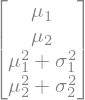

In [3]:
mu1, mu2, sig1, sig2, rho = symbols('mu_1 mu_2 sigma_1 sigma_2 rho', real=True)
sig1, sig2 = symbols('sigma_1 sigma_2', positive=True)

# Raw moments expectations E[X]
m1 = mu1
m2 = mu2
q1 = mu1**2 + sig1**2  # E[r1^2]
q2 = mu2**2 + sig2**2  # E[r2^2]

# The vector of means of observables
z_true = Matrix([m1, m2, q1, q2])
display(z_true)

### 2.2 Construct the Covariance of Raw Moments $\Gamma$
This involves fourth moments of the Normal distribution.
$\Gamma_{ij} = \text{Cov}(X_i, X_j)$.

Raw Moment Covariance Matrix Gamma:


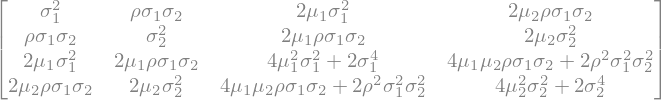

In [4]:
# We can compute these using standard Gaussian identities
# Cov(r_i, r_j) = sigma_ij
# Cov(r_i, r_j^2) = 2 * mu_j * sigma_ij (Isserlis)
# Cov(r_i^2, r_j^2) = 2 * sigma_ij^2 + 4 * mu_i * mu_j * sigma_ij

sigma12 = rho * sig1 * sig2
v1 = sig1**2
v2 = sig2**2

Gamma = sp.zeros(4, 4)

# Block 1: Cov(r, r)
Gamma[0, 0] = v1
Gamma[1, 1] = v2
Gamma[0, 1] = Gamma[1, 0] = sigma12

# Block 2: Cov(r, r^2)
# Cov(r1, r1^2) = E[r1^3] - E[r1]E[r1^2]. For normal X~N(0,v), E[X^3]=0. r = mu + eps.
# Actually simpler: Cov(r, r^2) = 2*mu*Var(r)
Gamma[0, 2] = Gamma[2, 0] = 2 * mu1 * v1
Gamma[0, 3] = Gamma[3, 0] = 2 * mu2 * sigma12
Gamma[1, 2] = Gamma[2, 1] = 2 * mu1 * sigma12
Gamma[1, 3] = Gamma[3, 1] = 2 * mu2 * v2

# Block 3: Cov(r^2, r^2)
# Cov(r1^2, r1^2) = Var(r1^2) = 2*sigma1^4 + 4*mu1^2*sigma1^2
Gamma[2, 2] = 2*v1**2 + 4*mu1**2*v1
Gamma[3, 3] = 2*v2**2 + 4*mu2**2*v2
# Cov(r1^2, r2^2) = 2*sigma12^2 + 4*mu1*mu2*sigma12
Gamma[2, 3] = Gamma[3, 2] = 2*sigma12**2 + 4*mu1*mu2*sigma12

print("Raw Moment Covariance Matrix Gamma:")
display(Gamma)

### 2.2b Covariance via sympy random variables (sanity check)
Build correlated normals with a two-factor representation and compute $\Gamma$ directly with `sympy.stats`; confirm it matches the closed form above.


Covariance from sympy random variables (Gamma_rv):


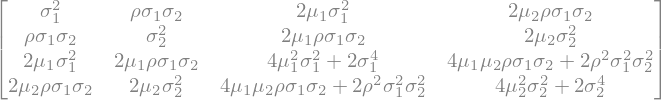

Difference Gamma_rv - Gamma (should be all zeros):


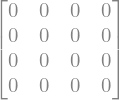

Numeric diff with sample params:


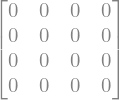

In [5]:
# Construct correlated normals r1, r2 using two independent standards (avoid positive assumptions by using temp sigmas)
sig1_free, sig2_free = symbols("sig1_free sig2_free", real=True)
X1 = Normal("X1", 0, 1)
X2 = Normal("X2", 0, 1)
r1_rv = mu1 + sig1_free * X1
r2_rv = mu2 + sig2_free * (rho * X1 + sp.sqrt(1 - rho**2) * X2)

Gamma_rv = sp.zeros(4, 4)
Gamma_rv[0,0] = covariance(r1_rv, r1_rv)
Gamma_rv[0,1] = Gamma_rv[1,0] = covariance(r1_rv, r2_rv)
Gamma_rv[0,2] = Gamma_rv[2,0] = covariance(r1_rv, r1_rv**2)
Gamma_rv[0,3] = Gamma_rv[3,0] = covariance(r1_rv, r2_rv**2)
Gamma_rv[1,1] = covariance(r2_rv, r2_rv)
Gamma_rv[1,2] = Gamma_rv[2,1] = covariance(r2_rv, r1_rv**2)
Gamma_rv[1,3] = Gamma_rv[3,1] = covariance(r2_rv, r2_rv**2)
Gamma_rv[2,2] = covariance(r1_rv**2, r1_rv**2)
Gamma_rv[3,3] = covariance(r2_rv**2, r2_rv**2)
Gamma_rv[2,3] = Gamma_rv[3,2] = covariance(r1_rv**2, r2_rv**2)

# Substitute back the original sigma symbols (with positivity assumptions)
Gamma_rv = Gamma_rv.subs({sig1_free: sig1, sig2_free: sig2})

print("Covariance from sympy random variables (Gamma_rv):")
display(Gamma_rv)

diff_mat = Gamma_rv - Gamma
print("Difference Gamma_rv - Gamma (should be all zeros):")
display(diff_mat)

# Quick numeric sanity check
num_subs = {mu1: 0.1, mu2: -0.05, sig1: 0.2, sig2: 0.25, rho: 0.3}
print("Numeric diff with sample params:")
display(diff_mat.subs(num_subs).evalf())

### 2.3 The Jacobian Transformation $J$
We map $z = (\hat\mu_1, \hat\mu_2, \hat q_1, \hat q_2)$ to $\theta = (\hat\mu_1, \hat\mu_2, \hat v_1, \hat v_2)$.
Relations:
$\hat v_i = \hat q_i - \hat\mu_i^2$

Jacobian Matrix J:


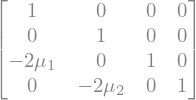

In [6]:
mu1_sym, mu2_sym, q1_sym, q2_sym = symbols('mu_1 mu_2 q_1 q_2')
z_vec = Matrix([mu1_sym, mu2_sym, q1_sym, q2_sym])

# Define theta(z)
theta_func = Matrix([
    mu1_sym,
    mu2_sym,
    q1_sym - mu1_sym**2,
    q2_sym - mu2_sym**2
])

J = theta_func.jacobian(z_vec)
# Substitute true values for expectations back in to evaluate Jacobian at the limit
J = J.subs({mu1_sym: mu1, mu2_sym: mu2})

print("Jacobian Matrix J:")
display(J)

### 2.4 Compute Parameter Covariance $\Omega = J \Gamma J^T$

Derived Parameter Covariance Omega:


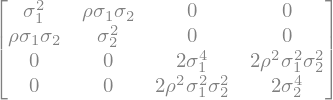

Verifying block structure (Var(v1) should be 2*v1^2):


True

In [7]:
Omega_derived = simplify(J * Gamma * J.T)
print("Derived Parameter Covariance Omega:")
display(Omega_derived)

# Check if this matches the block form stated in the notes
print("Verifying block structure (Var(v1) should be 2*v1^2):")
display(Omega_derived[2,2] == 2*v1**2)

### 2.5 Gradient of the Sharpe Difference
$f(\theta) = \frac{\mu_1}{\sigma_1} - \frac{\mu_2}{\sigma_2} = \mu_1 v_1^{-1/2} - \mu_2 v_2^{-1/2}$

Gradient Vector g:


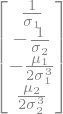

In [8]:
v1_sym, v2_sym = symbols('v_1 v_2')
psi = mu1_sym * v1_sym**(-Rational(1,2)) - mu2_sym * v2_sym**(-Rational(1,2))

theta_sym = Matrix([mu1_sym, mu2_sym, v1_sym, v2_sym])
g = psi.diff(theta_sym)

# Substitute true values
g = g.subs({mu1_sym: mu1, mu2_sym: mu2, v1_sym: v1, v2_sym: v2})
print("Gradient Vector g:")
display(g)

### 2.6 Final Variance Contraction
$\omega^2 = g^T \Omega g$

Final Asymptotic Variance Expression:


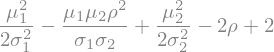

Difference from Target Formula (should be 0):


In [9]:
final_var = (g.T * Omega_derived * g)[0]
final_var = simplify(final_var)

print("Final Asymptotic Variance Expression:")
display(final_var)

# Let's match it against the target geometric formula
eta1 = mu1 / sig1
eta2 = mu2 / sig2

target = 2*(1-rho) + Rational(1,2)*(eta1**2 + eta2**2) - eta1*eta2*rho**2
diff_check = simplify(final_var - target)

print("Difference from Target Formula (should be 0):")
display(diff_check)

## Part 3: Numerical Monte Carlo Verification

We will now simulate $N=15,000$ experiments. In each experiment, we simulate $T=1,500$ points from a bivariate normal distribution, compute the difference of realized Sharpe ratios, and store it. Then we compare the variance of these differences to $\omega^2/T$.

In [10]:
def run_monte_carlo(mu, cov_matrix, T=1500, n_sims=15000):
    # Generate data: (n_sims, T, 2)
    # It's faster to generate all at once
    rng = np.random.default_rng(42)
    data = rng.multivariate_normal(mu, cov_matrix, size=(n_sims, T))
    
    # data shape: (n_sims, T, 2)
    # Compute means along axis 1 (time)
    means = np.mean(data, axis=1) # (n_sims, 2)
    stds = np.std(data, axis=1, ddof=0) # (n_sims, 2) - MLE uses 1/T, though ddof=1 is unbiased for var
    # Note: The derivation used 1/T (MLE) summing, but for T=1000 diff is negligible.
    
    sharpes = means / stds
    diff_sharpe = sharpes[:, 0] - sharpes[:, 1]
    
    mc_variance = np.var(diff_sharpe, ddof=1)
    return mc_variance * T  # Rescale by T to compare with omega^2

# Setup Parameters
mu_val = np.array([0.05, 0.03])
sig_val = np.array([0.15, 0.10])
rho_val = 0.6

cov_val = np.array([
    [sig_val[0]**2, rho_val*sig_val[0]*sig_val[1]],
    [rho_val*sig_val[0]*sig_val[1], sig_val[1]**2]
])

# Theoretical omega^2
eta1_val = mu_val[0]/sig_val[0]
eta2_val = mu_val[1]/sig_val[1]
theo_omega2 = 2*(1-rho_val) + 0.5*(eta1_val**2 + eta2_val**2) - eta1_val*eta2_val*rho_val**2

print(f"Theoretical Scaled Variance (omega^2): {theo_omega2:.5f}")

# Run MC
mc_res = run_monte_carlo(mu_val, cov_val, T=1500, n_sims=15000)
print(f"Monte Carlo Scaled Variance (T*Var):   {mc_res:.5f}")
print(f"Relative Error: {abs(mc_res - theo_omega2)/theo_omega2 * 100:.2f}%")

Theoretical Scaled Variance (omega^2): 0.86456
Monte Carlo Scaled Variance (T*Var):   0.86101
Relative Error: 0.41%


## Part 4: Bootstrap Sharpe-difference (paired returns)
Bootstrap approach from the note: resample paired returns, recompute Sharpe differences, and take quantiles for a CI.


In [11]:
def sharpe_diff(r1, r2):
    m1, m2 = np.mean(r1), np.mean(r2)
    s1, s2 = np.std(r1, ddof=0), np.std(r2, ddof=0)
    return m1 / s1 - m2 / s2

def bootstrap_sharpe_diff(r1, r2, B=2000, seed=0):
    rng = np.random.default_rng(seed)
    T = len(r1)
    idx = np.arange(T)
    diffs = np.empty(B)
    for b in range(B):
        resample = rng.choice(idx, size=T, replace=True)
        diffs[b] = sharpe_diff(r1[resample], r2[resample])
    point = sharpe_diff(r1, r2)
    ci = (np.quantile(diffs, 0.025), np.quantile(diffs, 0.975))
    return point, ci, diffs


In [12]:
# Demo with synthetic paired returns (same params as MC above)
rng = np.random.default_rng(123)
T_demo = 1500
mu_demo = np.array([0.05, 0.03])
sig_demo = np.array([0.15, 0.10])
rho_demo = 0.6
cov_demo = np.array([[sig_demo[0]**2, rho_demo*sig_demo[0]*sig_demo[1]],
                     [rho_demo*sig_demo[0]*sig_demo[1], sig_demo[1]**2]])
data_demo = rng.multivariate_normal(mu_demo, cov_demo, size=T_demo)
r1_demo, r2_demo = data_demo[:,0], data_demo[:,1]
point, ci, diffs = bootstrap_sharpe_diff(r1_demo, r2_demo, B=15000, seed=321)
print(f"Sample Sharpe diff: {point:.4f}")
print(f"Bootstrap 95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")

Sample Sharpe diff: 0.0420
Bootstrap 95% CI: (-0.0061, 0.0904)
